# *Joins & PCollection splitting*

*How to merge and brach PCollections*


Let's start installing and importing Beam

In [ ]:
%pip install -q apache-beam[interactive]==2.28.0 --no-warn-conflicts

Now, restart the runtime (either "*Runtime/Restart runtime*" in the top bar or *Ctrl+M*)

In [ ]:
import apache_beam as beam
from apache_beam import pvalue
from apache_beam import Create, FlatMap, Map, ParDo, Flatten, Partition
from apache_beam import Values, CoGroupByKey
from apache_beam import pvalue, window, WindowInto
from apache_beam.transforms import trigger
from apache_beam.transforms.periodicsequence import PeriodicImpulse

from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib

import time
import random

## PCollection Splitting 

We will see ways we can take a `PCollection` and output more than one `PCollection`.


This first example show us how to reference a `PCollection` in case we want to use the same input but perform different transforms. We can accomplish this just by referencing the previous `PCollection`. We are going to use this to extract each column from our input.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

elements = [
           {"name": "Rebecca", "sport": "Soccer"},
           {"name": "Tom", "sport": "Rugby"},
           {"name": "Guillem", "sport": "Volley"},
           {"name": "Ana", "sport": "Hockey"},
           {"name": "Alice", "sport": "Football"},
           {"name": "Kim", "sport": "Tennis"},
]

elements_pcol = p | "Create" >> Create(elements)

names = elements_pcol | "Names" >> Map(lambda x: x["name"])
sports = elements_pcol | "Sport" >> Map(lambda x: x["sport"])

ib.show_graph(p)
ib.show(names, sports)



---




What if we don't want all elements from the previous `PCollection` to go to the next input but we want to split the `PCollection`? We can use `Partition`.

**`Partition`** sends elements to different `PTransforms` following a given function. It applies a function element-wise which outputs the index of the pipeline which the element should go to.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

even, odd = (p | "Create Numbers" >> Create(range(10))
               | "Odd or Even" >> Partition(lambda n, partitions: n % 2, 2))
# lambda x,y: which partition fn, number partitions
# even is when the fn outputs 0, odd when it outputs 1

ib.show(even, odd)

In the previous example, the lambda function had in the left side `x % 2`, which will tell us to which index the element should go to, and in the right side `2`, which is the total of indexes the ouput will have. Try modifying the example to use `mod 3` instead of `mod 2`.

A common use of `Partition` is splitting our machine learning dataset into *train, test*.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

percentage = 0.9

test, train = (p | Create(range(100))
                 | Partition(lambda x, y: int(random.random() < percentage), 2))

ib.show(test, train)

---

This option still does not cover all possibilities. What if you wanted a particular element to fall into two or more different categories?

We can use `ParDo` and the `TaggedOutput` option to achieve this. This is the most flexible way to branch `PCollections`.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

class DifferentOutputsFn(beam.DoFn):
    def process(self, element, x, y):
        if element % x == 0:
            yield pvalue.TaggedOutput("x", element)

        if element % y == 0:
            yield pvalue.TaggedOutput("y", element)

        yield element


diff_outputs = (p | "Create" >> Create(range(8))
                  | "Split Outputs" >> ParDo(DifferentOutputsFn(), x=2, y=3).with_outputs("x", "y"))

multiple_x = diff_outputs.x
multiple_y = diff_outputs.y
all_outputs = diff_outputs[None] 

ib.show_graph(p)
ib.show(multiple_x, multiple_y, all_outputs)

Let's go through the code. 

We are sending the elements to three subsections:

- Containing the multiples of X and/or Y: 
    * To send elements to those sections, use `yield` to that tagged output: `yield pvalue.TaggedOutput("x", element)`
    * To retrieve elements from that pipeline, simply refer to the original subpipeline `diff_outputs` with the tagged key *x* or *y*: `diff_outputs.x`


- All elements: 
    * In this case, there is no need to specify the tagged output, so simply use `yield`
    * To get this output, reference the elements without a tag by using `diff_outputs[None]`
    
Also, let's check how the `ParDo` is being used:

- `ParDo(DifferentOutputsFn(), x=2, y=3).with_outputs("x", "y"))`
    * Use `with_outputs` to reference the name of the tagged outputs
    * Note how the parameters `x` and `y` are passed to the `DifferentOutputsFn` Clas

## PCollection Merging 

We have seen how to branch out `PCollections`, let's see how we can merge them back

**`Flatten`** combines two or more `PCollections` into one. It takes elements for all input `PCollections` and outputs them as one `PCollection`. It's the equivalent of `UNION` in SQL.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

elements_1 = [
           {"name": "Rebecca", "sport": "Soccer"},
           {"name": "Tom", "sport": "Rugby"},
           {"name": "Guillem", "sport": "Volley"}
]

elements_2 = [
           {"name": "Ana", "sport": "Hockey"},
           {"name": "Alice", "sport": "Football"},
           {"name": "Kim", "sport": "Tennis"},
]

create_1 = p | "Create 1" >> Create(elements_1)
create_2 = p | "Create 2" >> Create(elements_2)

# Left side of | has to be a tuple
flattened = (create_1, create_2) | Flatten()

ib.show_graph(p)
ib.show(flattened)

**`CoGroupByKey`** Aggregates all input elements by their key and allows downstream processing to consume all values associated with the key. While `GroupByKey` performs this operation over a single input collection and thus a single type of input values, `CoGroupByKey` operates over multiple input collections. As a result, the result for each key is a tuple of the values associated with that key in each input collection.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

jobs = [
    ("John", "Data Scientist"),
    ("Rebecca", "Full Stack Engineer"),
    ("John", "Data Engineer"),
    ("Alice", "CEO"),
    ("Charles", "Web Designer"),
    ("Ruben", "Tech Writer")
]

hobbies = [
    ("John", "Baseball"),
    ("Rebecca", "Football"),
    ("John", "Piano"),
    ("Alice", "Photoshop"),
    ("Charles", "Coding"),
    ("Rebecca", "Acting"),
    ("Rebecca", "Reading")
]

jobs_create = p | "Create Jobs" >> Create(jobs)
hobbies_create = p | "Create Hobbies" >> Create(hobbies)

cogbk = {"jobs": jobs_create, "hobbies": hobbies_create} | CoGroupByKey()

ib.show_graph(p)
ib.show(cogbk)

We can use **`CoGroupByKey`** as `join` with some modifications, just by going through the `CoGroupByKey` output. The next example is a inner join per element.

In [ ]:
def inner_join(element):
  name = element[0]
  jobs = element[1]["jobs"]
  hobbies = element[1]["hobbies"]
  joined =  [{"name": name,
              "job": job,
              "hobbie": hobbie}
             for job in jobs for hobbie in hobbies]
  return joined

join = cogbk | FlatMap(inner_join)

ib.show(join)

### Side Inputs

Pipelines can use `PCollections` as parameters in functions, using `Side Inputs`. This parameter can be treated as a dictionary, as a list, as a singleton, or as an iterable. More details in the [Apache Beam documentation](https://beam.apache.org/releases/pydoc/current/apache_beam.pvalue.html).

We use `Side Inputs` instead of `joins` when there's no direct relation between the the main input and side input but we want to enrinch our data or when the right size of the table is very small and fit in memory (broadcast join).

In [ ]:
p = beam.Pipeline(InteractiveRunner())

values = [
    {"currency": "USD", "amount": 2.728281},
    {"currency": "EUR", "amount": 3.141592},
    {"currency": "CHF", "amount": 1729},
]

eur = {"CHF": 1.05, "EUR": 1, "USD": 1.09}
usd = {"CHF": 0.966, "EUR": 0.912, "USD": 1}
chf = {"EUR": 0.944, "CHF": 1, "USD": 1.035}
rates = [
         ("EUR", eur),
         ("USD", usd),
         ("CHF", chf)
]


def change_currency(value, ratios):
    current = value["currency"]
    exchanged = {"Original": current}
    for key in ratios[current]:
        exchanged[key] = value["amount"] * ratios[current][key]
    return [exchanged]

rates_pc = p | "Rates" >> Create(rates)

exchange = (p | Create(values)
              | ParDo(change_currency, ratios=pvalue.AsDict(rates_pc)))

ib.show_graph(p)
ib.show(exchange)

Let's do now the `join` example we did before with `CoGroupByKey` but with side inputs. We are going to assume `jobs` is rather big but `hobbies` is small in size. This approach saves us shuffling the big dataset.

In [ ]:
p = beam.Pipeline(InteractiveRunner())

jobs = [
    ("John", "Data Scientist"),
    ("Rebecca", "Full Stack Engineer"),
    ("John", "Data Engineer"),
    ("Alice", "CEO"),
    ("Charles", "Web Designer"),
    ("Ruben", "Tech Writer")
]

hobbies = [
    ("John", "Baseball"),
    ("Rebecca", "Football"),
    ("John", "Piano"),
    ("Alice", "Photoshop"),
    ("Charles", "Coding"),
    ("Rebecca", "Acting"),
    ("Rebecca", "Reading")
]

def broadcast_inner_join(element, side_input):
  name = element[0]
  job = element[1]
  hobbies = side_input.get(name, [])

  joined =  [{"name": name,
              "job": job,
              "hobbie": hobbie}
             for hobbie in hobbies]
  return joined

hobbies_create = (p | "Create Hobbies" >> Create(hobbies) 
                    | beam.GroupByKey())
                )
jobs_create = p | "Create Jobs" >> Create(jobs)

boardcast_join = jobs_create | FlatMap(broadcast_inner_join, 
                                        side_input=pvalue.AsDict(hobbies_create))
                  

ib.show_graph(p)
ib.show(boardcast_join)

### Side Inputs and windows

The Side inputs also work on a Window basis.  

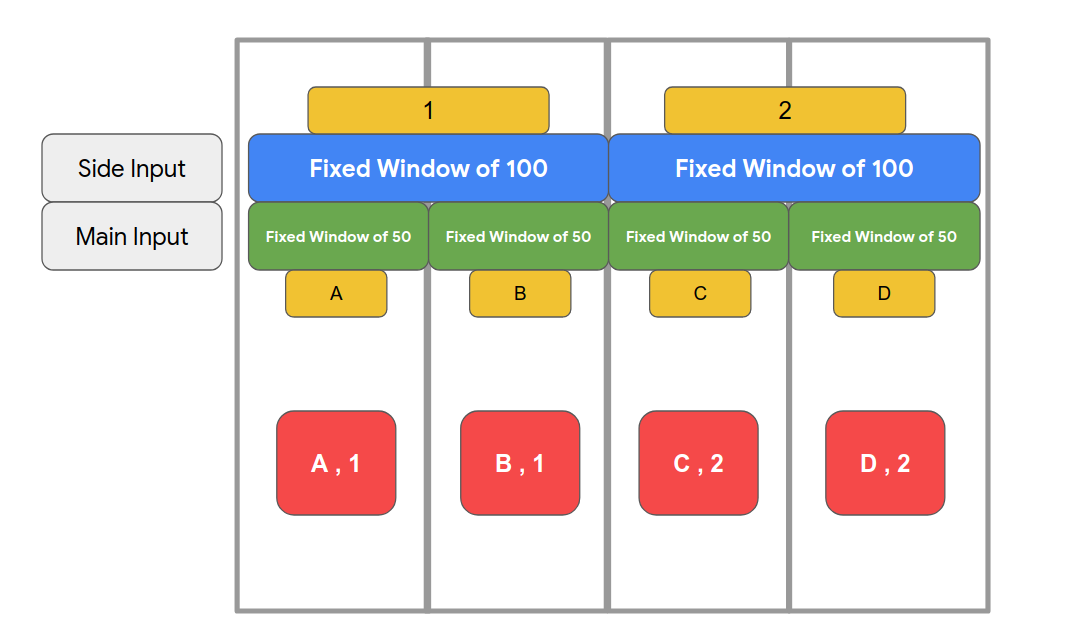 

In [ ]:
p = beam.Pipeline(InteractiveRunner())

values = [
    {"amount": 10, "timestamp": 0},
    {"amount": 5, "timestamp": 50},
    {"amount": 32, "timestamp": 100},
]

rates_USD_EUR = [
    {"rate": 0.91, "timestamp": 0},
    {"rate": 0.88, "timestamp": 100},    
]


def change_currency(value, rate):
    value["amount_EUR"] = value["amount"] * rate
    value["rate"] = rate
    return [value]

rates_pc = (p | "Rates" >> Create(rates_USD_EUR)
              | 'Add timestamps' >> Map(lambda x: window.TimestampedValue(x["rate"], x["timestamp"]))
              | "FixedWindow" >> WindowInto(window.FixedWindows(50))
            )

exchange = (p | "Values" >> Create(values)
              | 'Add timestamps Main' >> Map(lambda x: window.TimestampedValue(x, x["timestamp"]))
              | "FixedWindow Main" >> WindowInto(window.FixedWindows(100))
              | ParDo(change_currency, rate=pvalue.AsSingleton(rates_pc))
            )


ib.show(exchange)

### Streaming Example

We'll see this in Dataflow

In [ ]:
p = beam.Pipeline(DataflowRunner(), options)

topic = "projects/pubsub-public-data/topics/taxirides-realtime"


rates = [
        ("EUR", 0.91),
        ("CHF", 0.96),
]

def change_currency(row, ratios):
    new_row = row.copy()
    for key in ratios:
        new_row[f"meter_reading_{key}"] = new_row["meter_reading"] * ratios[key]

    logging.info(f"New row {new_row}")
    return [new_row]

rates_pc = p | "Rates" >> beam.Create(rates)

pubsub = (p | "Read Topic" >> ReadFromPubSub(topic=topic)
            | "Json Loads" >> Map(json.loads)
            | "Filter" >> Filter(lambda x: x["ride_status"] == "dropoff")
            | "Parse" >> Map(lambda x: {"ride_id": x["ride_id"], "meter_reading": x["meter_reading"]})
          )

join = pubsub | ParDo(change_currency, ratios=pvalue.AsDict(rates_pc))


p.run()